# RAPS with EuroSAT

In this notebook, we will demonstrate how you can use a posthoc conformal method like Regularized Adaptive Prediction Sets (RAPS) [Angelopoulos et al. 2021](https://arxiv.org/abs/2009.14193) on an Earth Observation (EO) Classification Task, namely the infamous EuroSAT dataset. For the dataloading we will use the [TorchGeo library](https://torchgeo.readthedocs.io/en/stable/), which you will need to install to run this tutorial (`pip install torchgeo`). We will use the smaller version `EuroSAT100` for demonstration purposes. Additionally, we will show how you can use a pretrained model - specific to EO data and apply RAPS for improved uncertainty quantification (UQ).

## Imports

In [39]:
import os
from torchgeo.datamodules import EuroSAT100DataModule
from torchgeo.models import ResNet18_Weights
from lightning_uq_box.uq_methods import DeterministicClassification, RAPS
import timm
import torch
from lightning import Trainer
import tempfile
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor

## Datamodule

In [2]:
datamodule = EuroSAT100DataModule(root=".", num_workers=4, download=True)
# setup manually so we can access val_loader
datamodule.setup("fit")

## Pretrained Model

We will use pretrained weights for Sentinel 2 data from the SSL4EO paper [Wang et al. 2022](https://arxiv.org/abs/2211.07044) that are accessible through TorchGeo.

In [3]:
weights = ResNet18_Weights.SENTINEL2_ALL_MOCO
in_chans = weights.meta["in_chans"]
resnet18 = timm.create_model("resnet18", in_chans=in_chans, num_classes=10)
resnet18.load_state_dict(weights.get_state_dict(progress=True), strict=False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

## Predictions with Pretrained Model

Let's first look at the predictions from the pretrained model so that we can later see the impact of RAPs. We will use a Lightning base class `DeterministicClassification` which will iterate over the dataloader and compute and store the metrics we are interested in.

In [4]:
base_dir = tempfile.mkdtemp()
# implement a torchmetrics empirical coverage metric and use that and accuracy to compare results
base_model = DeterministicClassification(resnet18, loss_fn=torch.nn.CrossEntropyLoss())
base_model.input_key = "image"
base_model.target_key = "label"

base_trainer = Trainer(accelerator="cpu", default_root_dir=base_dir)

base_trainer.validate(base_model, datamodule=datamodule)

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-p ...
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Missing logger folder: /tmp/tmp5am8d1vb/lightning_logs


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          valAcc           │    0.20000000298023224    │
│        valF1Score         │    0.20000000298023224    │
│         val_loss          │     2.344825506210327     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 2.344825506210327,
  'valAcc': 0.20000000298023224,
  'valF1Score': 0.20000000298023224}]

## Apply RAPS

In [5]:
raps_dir = tempfile.mkdtemp()
raps = RAPS(model=base_model.model, kreg=7, lamda_param=0)
raps.input_key = "image"
raps.target_key = "label"

raps_trainer = Trainer(
    accelerator="cpu", default_root_dir=raps_dir, inference_mode=False
)

raps_trainer.validate(raps, dataloaders=datamodule.val_dataloader())

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmpitsewql0/lightning_logs


Validation: |          | 0/? [00:00<?, ?it/s]

[{}]

## Example Visualization

In [13]:
predict_batch = next(iter(datamodule.val_dataloader()))

preds = raps.predict_step(predict_batch["image"])
print(preds.keys())

dict_keys(['pred', 'pred_set'])


In [22]:
preds["pred"].shape
eurosat_dataset = datamodule.train_dataloader().dataset
class_labels = eurosat_dataset.classes

In [69]:
def plot_random_sample(preds: dict[str, Tensor], images: Tensor, true_labels: Tensor, class_labels: list) -> None:
    """Plot a random sample from the prediction batch.

    Args:
        preds: dictionary containing 'pred' and 'pred_set'
        images: array of input images
        class_labels: list of class labels
    """
    # Select a random index from the prediction batch
    idx = np.random.randint(len(images))

    # Get the prediction set for the selected sample
    pred_set = preds['pred_set'][idx].numpy()
    mean_preds = preds['pred'][idx].numpy()

    # Get the corresponding class labels for the prediction set
    pred_labels = [class_labels[i] for i in pred_set]
    true_label = class_labels[true_labels[idx]]

    image = images[idx]

    # taken from Torchgeo plot method
    rgb_indices = []
    for band in eurosat_dataset.rgb_bands:
        if band in eurosat_dataset.bands:
            rgb_indices.append(eurosat_dataset.bands.index(band))
        else:
            raise ValueError("Dataset doesn't contain some of the RGB bands")

    image = np.take(image.numpy(), indices=rgb_indices, axis=0)
    image = np.rollaxis(image, 0, 3)
    image = np.clip(image / 3000, 0, 1)

    # Sort the mean predictions and corresponding class labels from high to low
    sorted_indices = np.argsort(mean_preds[pred_set])[::-1]
    sorted_mean_preds = mean_preds[pred_set][sorted_indices]
    sorted_pred_labels = [pred_labels[i] for i in sorted_indices]

    # Plot the input image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title('Input Image')

    # Plot the prediction set
    plt.subplot(1, 2, 2)
    plt.bar(range(len(sorted_mean_preds)), sorted_mean_preds)
    plt.xticks(range(len(sorted_mean_preds)), sorted_pred_labels, rotation='vertical')
    plt.title('Temp Scaled Logit Predictions')

    # Add the true label to the title
    plt.suptitle(f'Prediction Labels: {", ".join(sorted_pred_labels)}\nTrue Label: {true_label})')
    plt.tight_layout()
    plt.show()
    

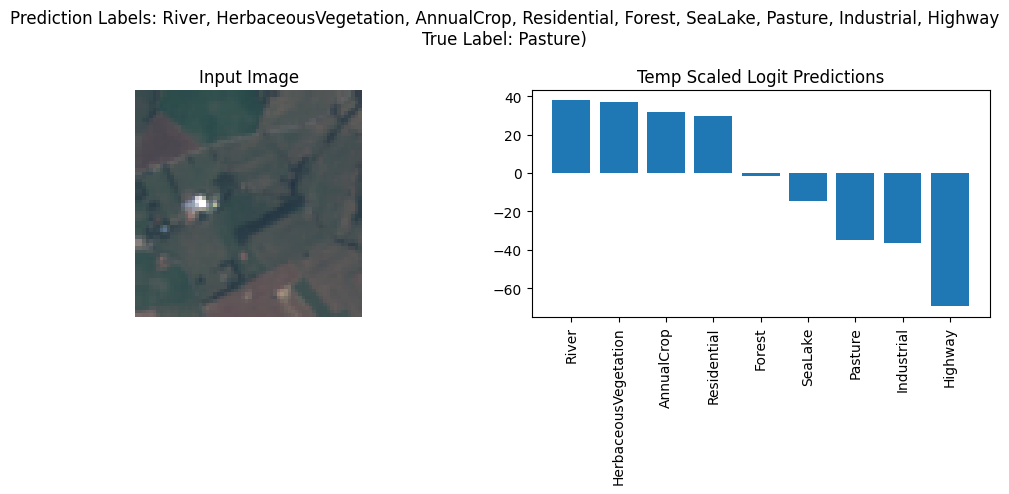

In [71]:
plot_random_sample(preds, predict_batch["image"], predict_batch["label"], class_labels)

In [72]:
# TODO demonstrate improved empirical coverage over baseline results
# do a bit of finetuning to see if we can improve the results